In [1]:
import os
import shutil
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

#### Using Pretrained Model VGG16 

In [2]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
            include_top=False,
            input_shape=(150, 150, 3))

In [3]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [4]:
from keras.preprocessing.image import ImageDataGenerator

In [5]:
base_dir = 'e:/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

#### Feature Extraction

In [6]:
def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

In [7]:
train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


#### Reshaping Image Tensors

In [8]:
train_features = np.reshape(train_features, (2000, 4*4* 512))
validation_features = np.reshape(validation_features, (1000, 4*4* 512))
test_features = np.reshape(test_features, (1000, 4*4* 512))

In [9]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

In [10]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
                loss='binary_crossentropy',
                metrics=['acc'])

In [11]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 5s 53ms/step - loss: 0.6039 - acc: 0.6750 - val_loss: 0.4398 - val_acc: 0.8400
Epoch 2/30
100/100 [==============================] - 5s 50ms/step - loss: 0.4248 - acc: 0.8155 - val_loss: 0.3696 - val_acc: 0.8450
Epoch 3/30
100/100 [==============================] - 5s 50ms/step - loss: 0.3596 - acc: 0.8510 - val_loss: 0.3269 - val_acc: 0.8750
Epoch 4/30
100/100 [==============================] - 5s 49ms/step - loss: 0.3162 - acc: 0.8680 - val_loss: 0.3008 - val_acc: 0.8790
Epoch 5/30
100/100 [==============================] - 5s 50ms/step - loss: 0.2871 - acc: 0.8885 - val_loss: 0.2784 - val_acc: 0.8910oss: 0.3025 - acc: 0.87 - ETA: 1s - loss: 0.3035 - acc - ETA: 1s - loss: 0.
Epoch 6/30
100/100 [==============================] - 5s 49ms/step - loss: 0.2646 - acc: 0.8995 - val_loss: 0.2686 - val_acc: 0.8880
Epoch 7/30
100/100 [==============================] - 5s 49ms/step - loss: 0.2529 - acc: 0.9000 - val_loss: 0.2628 - val_acc: 0

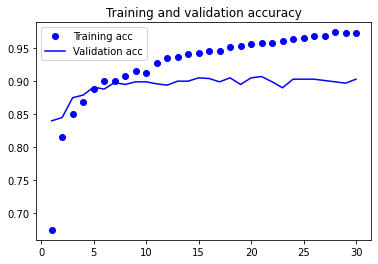

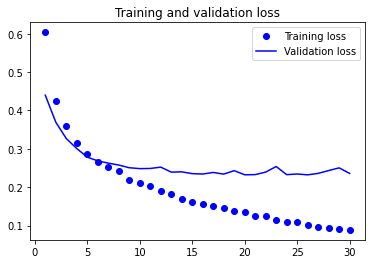

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Fine Tuning 

In [13]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [14]:
model.compile(loss='binary_crossentropy',
                optimizer=optimizers.RMSprop(lr=1e-5),
                metrics=['acc'])

In [15]:
history2 = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 5s 51ms/step - loss: 0.0830 - acc: 0.9795 - val_loss: 0.2376 - val_acc: 0.9030
Epoch 2/30
100/100 [==============================] - 4s 45ms/step - loss: 0.0803 - acc: 0.9775 - val_loss: 0.2427 - val_acc: 0.8990
Epoch 3/30
100/100 [==============================] - 4s 45ms/step - loss: 0.0777 - acc: 0.9805 - val_loss: 0.2412 - val_acc: 0.9000
Epoch 4/30
100/100 [==============================] - 6s 60ms/step - loss: 0.0791 - acc: 0.9745 - val_loss: 0.2369 - val_acc: 0.9020775 - acc: 0.9 - ETA: 0s - loss: 0.0792 - acc
Epoch 5/30
100/100 [==============================] - 5s 51ms/step - loss: 0.0746 - acc: 0.9830 - val_loss: 0.2453 - val_acc: 0.8980
Epoch 6/30
100/100 [==============================] - 5s 47ms/step - loss: 0.0736 - acc: 0.9785 - val_loss: 0.2393 - val_acc: 0.9020
Epoch 7/30
100/100 [==============================] - 4s 44ms/step - loss: 0.0719 - acc: 0.9835 - val_loss: 0.2394 - val_acc: 0.9030
Epoch 8/30
100/100 [====

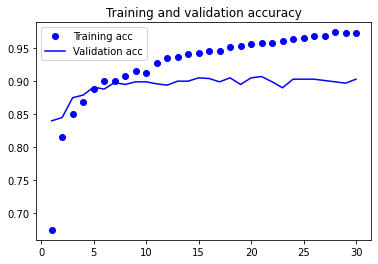

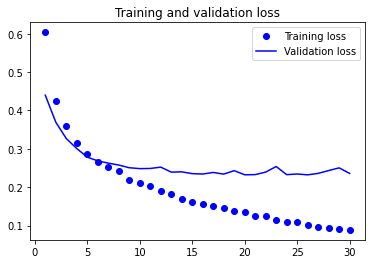

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [18]:
test_loss, test_acc = model.evaluate(test_features, test_labels)
print('test acc:', test_acc)

32/32 [==============================] - 0s 8ms/step - loss: 0.2734 - acc: 0.8840
test acc: 0.8840000033378601
